# Spatial Exploratory Data Analysis (EDA)

This notebook will present some spatial EDA which will happen prior to spatial modelling. We use the [Philippine Statistics Authority (PSA) municipality poverty estimates](https://psa.gov.ph/content/psa-releases-2018-municipal-and-city-level-poverty-estimates) dataset, which have been joined with PSGC master table to get the geometry columns.

It covers of 2 main concepts:
- Spatial Weight/ Lags
- Spatial Autocorrelation

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle

import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
# PSA national census data
file = open('data/master_geom_l3.pkl', 'rb')

l3_df = pickle.load(file)
l3_df = gpd.GeoDataFrame(l3_df, crs="EPSG:4326", geometry=l3_df['geometry'])
l3_df.head()

,data_updated,filename,geo_tab_pop,geo_tab_age_gender,geo_tab_popgrowthrate,geo_tab_poverty,geo_lvl_1,geo_lvl_2,geo_lvl_3,tot_pop,...,children,working,elder,children_pct,working_pct,elder_pct,pop_growth_pct,poverty_pct,name,geometry
0,2020-05,Region 10.xlsx,bukidnon,Reg X,R10,no HUC,REGION X (NORTHERN MINDANAO),Bukidnon,Baungon,654.0,...,16517.0,16556.0,4036.0,0.445094,0.446145,0.108761,0.016485,0.3465,Bukidnon_Baungon,"MULTIPOLYGON (((124.73040 8.25820, 124.73480 8..."
16,2020-05,Region 10.xlsx,bukidnon,Reg X,R10,no HUC,REGION X (NORTHERN MINDANAO),Bukidnon,Damulog,458.0,...,18606.0,17100.0,3595.0,0.473423,0.435103,0.091473,0.056348,0.3544,Bukidnon_Damulog,"MULTIPOLYGON (((124.92800 7.51860, 124.93310 7..."
33,2020-05,Region 10.xlsx,bukidnon,Reg X,R10,no HUC,REGION X (NORTHERN MINDANAO),Bukidnon,Dangcagan,2537.0,...,11786.0,11151.0,3131.0,0.452125,0.427766,0.120109,0.020094,0.2764,Bukidnon_Dangcagan,"MULTIPOLYGON (((125.06490 7.57430, 125.06590 7..."
47,2020-05,Region 10.xlsx,bukidnon,Reg X,R10,no HUC,REGION X (NORTHERN MINDANAO),Bukidnon,Doncarlos,539.0,...,30104.0,30973.0,8195.0,0.434577,0.447121,0.118302,0.007173,0.2706,Bukidnon_Doncarlos,"MULTIPOLYGON (((125.05110 7.66950, 125.05310 7..."
76,2020-05,Region 10.xlsx,bukidnon,Reg X,R10,no HUC,REGION X (NORTHERN MINDANAO),Bukidnon,Impasug-Ong,889.0,...,24742.0,23662.0,4868.0,0.464447,0.444173,0.091380,0.025175,0.3379,Bukidnon_Impasug-Ong,"MULTIPOLYGON (((124.99720 8.21110, 124.98680 8..."


# Spatial Weights/ Lag

Spatial lag operator is one of the most common and direct applications of spatial weights matrices ($\textbf{W}$’s) in spatial analysis. It is the product of $\textbf{W}$ and the vector of a given variable:

$Y_{sl} = \textbf{W} Y$ OR $y_{sl-i} = \sum_j w_{ij}y_j$

Spatial lag captures the behavior of a variable in the immediate surroundings of each location.

where $w_{ij}$ is the cell in $\textbf{W}$ on the $i^{th}$ row and $j^{th}$ column, thus capturing the spatial relationship between observations $i$ and $j$. $y_{sl-i}$ then captures the product of the values and weights of each observation other than $i$ in the dataset. Because non-neighbors receive a weight of 0, $y_{sl-i}$ really captures the product of values and weights for $i$’s neighbors.

* If $\textbf{W}$ is binary, this will amount to the sum of the values of $i$’s neighbors.
* If $\textbf{W}$ is row standardized, a common transformation, then $w_{ij}$ is bounded between 0 and 1. The spatial lag thus becomes a “local average" (the average value of  in the neighborhood of each observation). This will enable analysis of spatial autocorrelation.

In [3]:
from pysal.explore import esda
from pysal.lib import weights
from splot.esda import plot_moran
from splot import esda as esdaplot

In [4]:
target = l3_df[["name", "poverty_pct", "geometry"]].dropna(subset=["poverty_pct", "geometry"])

In [5]:
# Generate W from the GeoDataFrame
w = weights.KNN.from_dataframe(target, k=8)

# Row-standardization
w.transform = "R"

/Users/nicole_kan/opt/anaconda3/envs/gdai-env/lib/python3.10/site-packages/pysal/lib/weights/util.py:1026: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  data = np.vstack([np.array(shape.centroid) for shape in iterable])


In [6]:
target["poverty_pct_lag"] = weights.spatial_lag.lag_spatial(w, target["poverty_pct"])

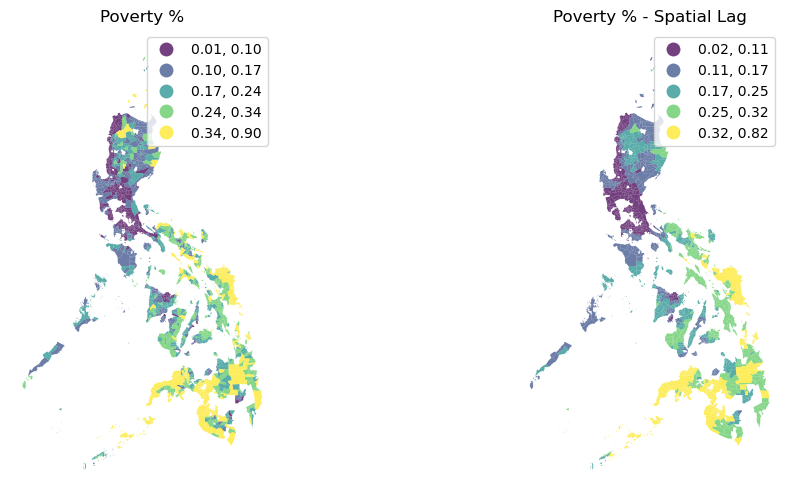

In [7]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = axs

target.plot(
    column="poverty_pct",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax1,
)
ax1.set_axis_off()
ax1.set_title("Poverty %")

target.plot(
    column="poverty_pct_lag",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    ax=ax2,
)
ax2.set_axis_off()
ax2.set_title("Poverty % - Spatial Lag")

plt.show()

# Spatial autocorrelation
Degree to which the similarity in values between observations is related to proximity of their locations

<img src="images/spatial-autocorr-example.png" alt="Drawing" width="500" height="200"/>

## Traits
* Positive Autocorrelation: similar values are located **near** each other. Different values are scattered and further away (e.g. distribution of poverty)
* Negative Autocorrelation: similar values located **away** from each other (e.g. ditribution of supermarkets of different brands/ hospitals)

* Global Autocorrelation: overall trend that location of values follow, providing insights about **degree of clustering** in dataset
* Local Autocorrelation: deviation of **individual points** from the global trend

## Global Moran's I
(For continuous variables)

Spatial lag plays an important role in quantifying spatial autocorrelation. Using it, we can relate the behavior of a variable at a given location to its pattern in the immediate neighborhood. Measures of global spatial autocorrelation will then use each observation to construct overall measures about the general trend in a given dataset.

Moran's I: 

$ I = \frac{n}{\sum_i \sum_j w_{ij}} * \frac{\sum_i \sum_j w_{ij}z_iz_j}{\sum_i z_i^2}$

where $n$ is the number of observations, $z_i$ is the standardised value of the variable of interest at location $i$ and $w_{ij}$ is the cell corresponding to the $i^{th}$ row and $j^{th}$ column of a $\textbf{W}$ spatial weights matrix.

The Moran Plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It a scatter plot in where the target variable is displayed against its spatial lag. To interpret whether the values are above or below the mean, the target variable is usually standardized by subtracting its mean.

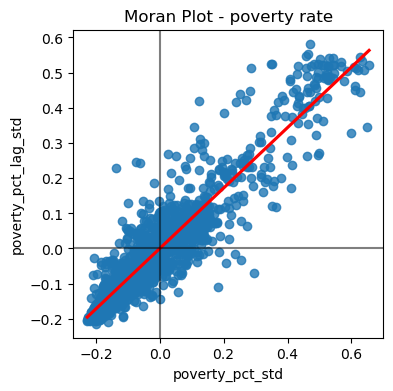

In [10]:
target["poverty_pct_std"] = target["poverty_pct"] - target["poverty_pct"].mean()
target["poverty_pct_lag_std"] = (target["poverty_pct_lag"] - target["poverty_pct_lag"].mean())

f, ax = plt.subplots(1, figsize=(4, 4))
sb.regplot(
    x="poverty_pct_std",
    y="poverty_pct_lag_std",
    ci=None,
    data=target,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot - poverty rate")
plt.show()

* Scatter plot ofthe variable of interest (poverty_pct) against its spatial lag
* Shows the average standardised value in the neighbourhood of each observation
* Red line: best linear fit to the scatter plot (Moran's I)
* Poverty Rate has positive spatial autocorrelation --> more clustering --> neighbourhood areas will have more similar values

In [ ]:
w.transform = "R"
moran = esda.moran.Moran(target["poverty_pct"], w)
print("Global Moran's I: ", moran.I)

Global Moran's I:  0.8591479880086347


## Local Moran's I

WHY: Spatial autocorrelation may not be the same throughout all areas (e.g. urban vs rural)

Motivation:
* Global Moran's I tells us **whether** values in map cluster together, but not **where** the clusters are
* Local Moran's I aims to identify cases in which the value of an observation and the average of its surroundings is either more similar (HH/LL) or dissimilar (HL/LH) than we would expect from pure chance (no spatial structure)

Local Moran’s I ⇒ similar to global Moran’s I, but applied to every observation ⇒ this results in many statistics as original observations

$I_i = \frac{z_i}{m_2} \sum_j w_{ij}z_j$

$m_2=\frac{\sum_i z_i^2}{n}$,

where $m_2$ is the second moment (variance) of the distribution of values in the data

$z_i=y_i-\bar y$

$n$ is the number of observations

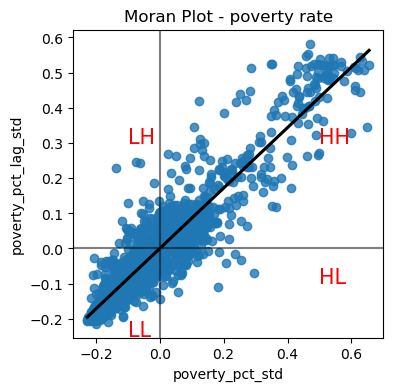

In [16]:
# Moran Plot
f, ax = plt.subplots(1, figsize=(4, 4))
sb.regplot(
    x="poverty_pct_std",
    y="poverty_pct_lag_std",
    ci=None,
    data=target,
    line_kws={"color": "k"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)

plt.text(0.5, 0.3, "HH", fontsize=15, c="r")
plt.text(0.5, -0.1, "HL", fontsize=15, c="r")
plt.text(-0.1, 0.3, "LH", fontsize=15, c="r")
plt.text(-0.1, -0.25, "LL", fontsize=15, c="r")

ax.set_title("Moran Plot - poverty rate")
plt.show()

Intuitively:
* HH: poorer areas clustered together
* LL: wealthy areas clustered together
* LH: wealthy areas are near poorer areas
* HL: poorer areas are near wealthy areas

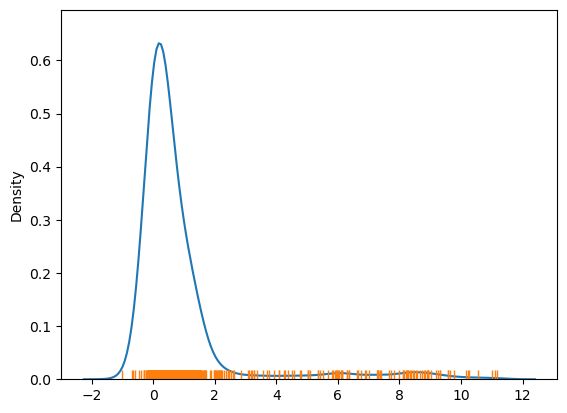

In [17]:
lisa = esda.moran.Moran_Local(target["poverty_pct"], w)

# Draw KDE line
ax = sb.kdeplot(lisa.Is)

# Add one small bar (rug) for each observation
# along horizontal axis
sb.rugplot(lisa.Is, ax=ax);

Most Local Moran's I value is positive --> dominance of postive spatial association

But which are the statistically significant values that should be looked into?

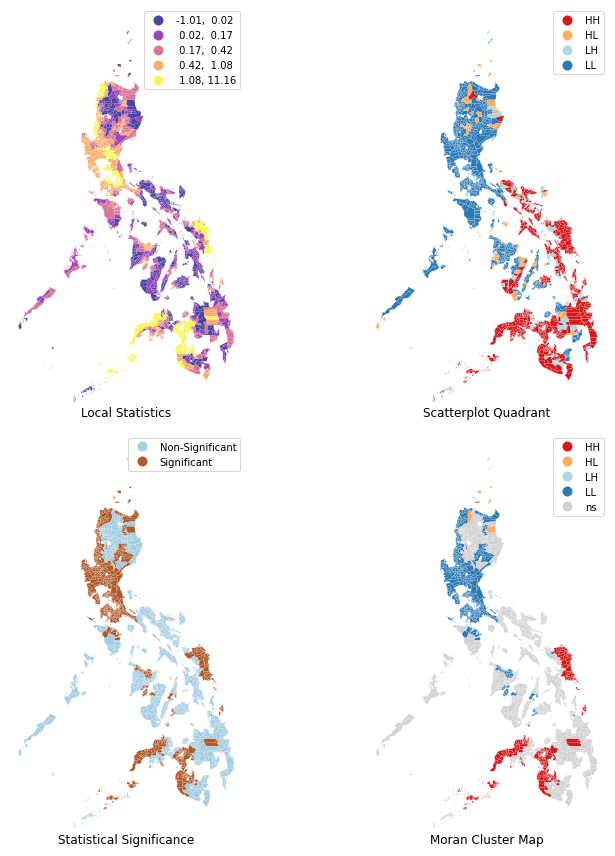

In [ ]:
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
ax = axs[0]
target.assign(
    Is=lisa.Is
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
ax = axs[1]
esdaplot.lisa_cluster(lisa, target, p=1, ax=ax)

# Subplot 3 #
# Significance map
ax = axs[2]
# Find out significant observations
labels = pd.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=target.index        # Use the index in the original data
                              # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
target.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
ax = axs[3]
esdaplot.lisa_cluster(lisa, target, p=0.05, ax=ax)
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )

f.tight_layout()
plt.show()

<img src="images/local-moran-signif.png" alt="Drawing" width="1200" height="600"/>